## Caroline Rhote-Vaney

## PHY 415

## Project 5

## Dec. 2-4 2022

In [3]:
import seaborn as sns
sns.set()
from math import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq
import scipy.signal as sig
from scipy.io.wavfile import write
from math import *
%matplotlib inline

# 0. The Solar System Symphony - What Does our Solar System Sound Like?
---------------------------------------------------------------------------------------------------------------------------
In this project, I am aiming to model the solar system using a central force based attractive potential model. I will then superpose all the resulting planetary motions to create a sound. I am mainly wondering, will it sound good? It most likely won't, so then I also have to ask - how can we maniuplate this sound using fft's? Will we be able to achieve a nicer "characteristic" sound of the solar system?

This project will be a mix of modeling second order ODE's and performing FFT manipulations. The 1st part of this project involving the actual planetary modeling involves a lot of code made by me over the summer. I won't bother to explain the exact functionality of the planet/system classes I made. The relevance of this code to the project is just that it is a vector for me to be able to 1) perform an integration of a multi-body system and 2) to be able to eventually work with FFTs. In addition, I will not be explaining the ways in which I chose the parameters for the force function right below or for how I chose the initial conditions of my system in detail. I will be providing basic information for this but I want to emphasize that this code serves to facilitate me in my goal of creating a characteristic sound for this system.

---------------------------------------------------------------------------------------------------------------------------
limitations:

- This is a simple model. I will not be able to encapsulate the exact phase difference between planetary motion realistically, as I make them all start on the same positive x axis.

- This is a big system, and so the cell that will run the integration will take up to a few minutes to run, meaning I cannot work with a big enough dataset to change frequencies of the main peaks in the FFT, as this would involve removing too many points and would render the final sound too short to listen to.

- going off the point above, the closest way I will be able to manipulate the frequency level in this manner will be to modify the samplerate when creating the sound (so not an FFT manipulation).

- The integration method I will be using (velocity verlet) will have an error that won't be detrimental, but will be hard to reduce since the only way to do this would be to lessen the timestep, and the system would take too long to load. This may affect the nature of the resulting noise.

---------------------------------------------------------------------------------------------------------------------------

#### note: not all functions in the planet/system classes below will be relevant to this project. please ignore this.
---------------------------------------------------------------------------------------------------------------------------

# 1.  Modeling the system using object-oriented programming and the velocity verlet method
---------------------------------------------------------------------------------------------------------------------------
As said above, we will not be focusing on the ins and outs of this code. However, I would like to talk about the basis for it.

The gravitational forces between planets can be modeled by using an attractive potential $V(r) = \frac{-\alpha}{r}$. This is the potential between two objects with positions and velocities $r_{1}$  $\dot{r_{1}}$, and $r_{2}$  $\dot{r_{2}}$ respectively, and with a relative position $|r_2 - r_1|$.

I will not conduct a full legrangian examination here, but the resulting 2-body legrangian for a system in this potential would be:

$$ L = K-U = \frac{m}{2}(\dot{r_{1}}^2 + \dot{r_{2}}^2)+\frac{\alpha}{|r_2 - r_1|}$$

Solving $$\frac{\partial{L}}{\partial{r_1}} = \frac{d}{dt}\frac{\partial{L}}{\partial{\dot{r_1}}}$$

$$\frac{\partial{L}}{\partial{r_2}} = \frac{d}{dt}\frac{\partial{L}}{\partial{\dot{r_2}}}$$

You get the equations of motion here.

$$ m\ddot{r_1} = \frac{-\alpha}{r^2}\hat{r_1}$$

$$ m\ddot{r_2} = \frac{\alpha}{r^2}\hat{r_2} $$

We can notice these results are consistent with newton's third law, as we would expect from this potential, where $F_{21} = -F_{12}$

---------------------------------------------------------------------------------------------------------------------------
The integration is made possible by the force function below, which calculates the net force on each planet by every other planet. Basically, take the idea above and generalize this to a system of more than two bodies. 

The initial conditions are just based on the conditions for circular motion. 

All positions are scaled in terms of AU. All masses are authentic. This is supposed to be a realistic model of our solar system.

---------------------------------------------------------------------------------------------------------------------------

## 1.1 - Establishing classes and functions that will build the system

In [4]:
def force_planet(planet_positions, planet_mass, planet_index):
    #returns net force based on planet positions and planet index.
    
    n = len(planet_positions)
    net_forces = np.zeros((n,2))
    alpha = 4*pi*pi
    sum = 0
    
    for i in range(n):
        
        if i != planet_index:
            rel_positions = planet_positions[planet_index] - planet_positions[i] 
            
            r_absolute = (rel_positions[0]**2+rel_positions[1]**2)**0.5

            net_forces[i] = -((alpha*planet_mass[i]/planet_mass[0])*rel_positions)/(r_absolute**3)
            
        else:
            net_forces[i] = np.array([0,0]) #if get rid of this, could model binary systems, and system more accurately
            
    for j in net_forces:
        sum += j
    
    return sum

#### setting up the system (defining initial conditions, masses, and creating the system)

In [5]:
DeltaT = 0.001 
tfinal = 100
n = int(tfinal/DeltaT)
t = np.zeros(n)

v_j = np.zeros((n,2)) #jupiter
v_e = np.zeros((n,2)) #earth
v_me = np.zeros((n,2)) #mercury (addition 1)
v_ma = np.zeros((n,2)) #mars (addition 2)
v_v = np.zeros((n,2)) #venus (addition 3)
v_sa = np.zeros((n,2)) #saturn (addition 4)
v_u = np.zeros((n,2)) #uranus (addition 5)
v_n = np.zeros((n,2)) #neptune (addition 6)
v_p = np.zeros((n,2)) #pluto (addition 7)

r_j = np.zeros((n,2))
r_e = np.zeros((n,2))
r_me = np.zeros((n,2)) #1
r_ma = np.zeros((n,2)) #2
r_v = np.zeros((n,2)) #3
r_sa = np.zeros((n,2)) #4
r_u = np.zeros((n,2)) #5
r_n = np.zeros((n,2)) #6
r_p = np.zeros((n,2)) #6
r_s = np.array([0,0])

r0_j = np.array([5.2,0.0])
r0_e = np.array([1.0,0.0])
r0_me = np.array([0.39,0.0]) #1
r0_ma = np.array([1.52,0.0]) #2
r0_v = np.array([0.72,0.0]) #3
r0_sa = np.array([9.54,0.0]) #4
r0_u = np.array([19.19,0.0]) #5
r0_n = np.array([30.06,0.0]) #6
r0_p = np.array([39.53,0.0]) #7

v0_e = np.array([0.0, (2*pi)/(r0_e[0])**0.5]) #initial condition required for circular orbit is used here
v0_j = np.array([0.0, (2*pi)/(r0_j[0])**0.5])
v0_me = np.array([0.0, (2*pi)/(r0_me[0])**0.5]) #1
v0_ma = np.array([0.0, (2*pi)/(r0_ma[0])**0.5]) #2
v0_v = np.array([0.0, (2*pi)/(r0_v[0])**0.5]) #3
v0_sa = np.array([0.0, (2*pi)/(r0_sa[0])**0.5]) #4
v0_u = np.array([0.0, (2*pi)/(r0_u[0])**0.5]) #5
v0_n = np.array([0.0, (2*pi)/(r0_n[0])**0.5]) #6
v0_p = np.array([0.0, (2*pi)/(r0_p[0])**0.5]) #7


r_j[0] = r0_j
r_e[0] = r0_e
r_me[0] = r0_me #1
r_ma[0] = r0_ma #2
r_v[0] = r0_v #3
r_sa[0] = r0_sa #4
r_u[0] = r0_u #5
r_n[0] = r0_n #6
r_p[0] = r0_p #7

v_j[0] = v0_j
v_e[0] = v0_e
v_me[0] = v0_me #1
v_ma[0] = v0_ma #2
v_v[0] = v0_v #3
v_sa[0] = v0_sa #4
v_u[0] = v0_u #5
v_n[0] = v0_n #6
v_p[0] = v0_p #7

alpha = 4*pi*pi
m_j = 1.9*(10**27)
m_s = 2*(10**30)
m_e = 6*(10**24)
m_me = 3.3*(10**23) #1
m_ma = 6.6*(10**23) #2
m_v = 4.9*(10**24) #3
m_sa = 5.5*(10**26) #4
m_u = 8.8*(10**25) #5
m_n = 1.03*(10**26) #6
m_p = 1.3*(10**22) #7

planet_masses = np.array([m_s,m_me,m_v,m_e,m_ma,m_j,m_sa,m_u,m_n,m_p])

#### building a planet class

In [6]:
class mss_object():
    
    def __init__(self, mass, radius, position_arr_i, velocity_arr_i, sort): 
        
        self.mass = mass
        self.radius = radius
        self.position = position_arr_i
        self.velocity = velocity_arr_i
        self.status = sort
        self.hit = False 
        
    def force(self):
         
        c = 4*pi*pi
        return (c*self.mass)/(self.position)**2
    
    def hit(self, rogue_position, rogue_radius):
        
        rel_dist = rogue_position - self.position
        seperation_dist = (rel_dist[0]**2+rel_dist[1]**2)**0.5
        
        if seperation_dist < (rogue_radius + self.radius):
            
            self.mass = 0 #this essentially removes a planet if touched by comet
            
    def new_pos(self, new):
        
        self.position = new
    
    def new_vel(self, new):
        
        self.velocity = new
        
    def get_mass(self):
        return self.mass
    
    def get_radius(self):
        return self.radius
        
    def get_position(self):
        return self.position
    
    def get_type(self):
        return self.status
    
    def get_velocity(self):
        return self.velocity

#### building a composite system class

The verlocity verlet method is camputed using this class.

In [7]:
class system():
    
    def __init__(self, mss_object_array, dt, n):
        
        self.objects = mss_object_array
        self.accelerations = np.zeros((len(mss_object_array),2))
        self.n = n
        self.dt = dt        
        
    def get_masses(self):
        
        mass_list = []
        
        for i in self.objects:
            mass = i.get_mass()
            mass_list.append(mass)
            
        return np.array(mass_list)
    
    def get_positions(self):
        positions_list = []
        
        for i in self.objects:
            pos = i.get_position()
            positions_list.append(pos)
            
        return np.array(positions_list) #2d array
    
    def get_velocities(self):
        velocities_list = []
        
        for i in self.objects:
            vel = i.get_velocity()
            velocities_list.append(vel)
            
        return np.array(velocities_list) #2d array
    
    def get_radii(self):
        radius_list = []
        
        for i in self.objects:
            rad = i.get_radius()
            radius_list.append(rad)
            
        return np.array(radius_list)
    
    def forces(self):
        force_list = []
        
        for i in self.objects:
            force = i.force()
            force_list.append(force)
            
        return np.array(force_list) 
    
    def net_acceleration(self):
        net_acc_list = []
        masses = self.get_masses()
        positions = self.get_positions()
        
        for i in range(len(self.objects)):
            
            acc = force_planet(positions, masses, i)
            
            net_acc_list.append(acc)
        
        self.accelerations = np.array(net_acc_list)    
        #return np.array(net_acc_list)
    
    def get_system_type(self):
        t_list = []
        
        for i in self.objects:
            t = i.get_type()
            t_list.append(t)
            
        return np.array(t_list)
    
    def destroy_select(self, index):
                
        self.objects = np.delete(self.objects, index, axis = 0)
        self.accelerations = np.delete(self.accelerations, index, axis = 0)
                
#SETTING NEW VARIABLES TO UPDATE SYSTEM

    def set_new_position(self, new_pos_array):
        
        for i in range(len(self.objects)):
            self.objects[i].position = new_pos_array[i]
            
    def set_new_velocity(self, new_vel_array):
        
        for i in range(len(self.objects)):
            self.objects[i].velocity = new_vel_array[i]
                
    
#VELOCITY VERLET COMPUTATIONS

    def update_position(self,dt): 
        
        '''
        returns updated position, current acceleration before position change
        also sets new position so can get new acceleration in the next step.
        '''

        positions = self.get_positions()
        velocities = self.get_velocities()
        #not updating acceleration here.
        
            
        updated_positions = positions + dt*velocities + (dt**2)*self.accelerations/2
        
        self.set_new_position(np.array(updated_positions))
        return updated_positions, self.accelerations
        
    def update_velocity(self,acc1,dt):
        
        '''returns and sets a new velocity.
        
        get dt by doing self.dt outside the class'''
        
        velocity = self.get_velocities()
        acc_update = self.net_acceleration() #this should be updated, since the last function updates position.
        #acceleration = self.accelerations
        
            
        updated_velocities = velocity + 0.5*dt*(self.accelerations + acc1)
            
        self.set_new_velocity(np.array(updated_velocities))
        return np.array(updated_velocities)
        

#### defining planets

In [8]:
sun = mss_object(m_s, 0.0046547, np.array([0,0]), np.array([0,0]), "planet")
mercury = mss_object(m_me, 2.5788*(10**-5), r0_me, v0_me, "planet")
venus = mss_object(m_v, 4.04537*(10**-5), r0_v, v0_v, "planet")
earth = mss_object(m_e, 4.2635*(10**-5), r0_e, v0_e, "planet")
mars = mss_object(m_ma, 2.2657*(10**-5), r0_ma, v0_ma, "planet")
jupiter = mss_object(m_j, 4.6733*(10**-4), r0_j, v0_j, "planet")
saturn = mss_object(m_sa, 3.893*(10**-4), r0_sa, v0_sa, "planet")
uranus = mss_object(m_u, 1.6953*(10**-4), r0_u, v0_u, "planet")
neptune = mss_object(m_n, 1.64583*(10**-4), r0_n, v0_n, "planet")

sys = np.array([sun,mercury,venus,earth,mars,jupiter,saturn,uranus,neptune])

tf = 1000
dt = 0.01
n = round(tf/dt)

#### defining the system class using the planets

In [9]:
our_home = system(sys, dt, n)

## 1.2 - computing and visualizing the planet trajectories
---------------------------------------------------------------------------------------------------------------------------

#### Obtaining position fit enough to model sound:

The cell below will run the velocity verlet integration method, which I built into my above classes. It will use the system _our_home_ that I prepared in the cell right above. This contains all the necessary information (initial conditions) to be able to start the integration. Since this is an 9-body system, __it will take a while to run__ . 

There were limitations here, both from the standpoint of the limits of the v-verlet method and from wanting to model enough cycles to obtain at least a couple periods from the outermost planet neptune. I wanted the outer planets to be heard, not just the inner planets. As I have talked about above, the velocity verlet method has an amount of error that can only be reduced by decreasing the timestep. Since this also takes a long time to run, I had to compromise between having a small timestep, and having as many points as I can while also encompassing a couple periods from neptune. 

I needed many points because as you will see in 2.2 below, I had to be able to change the samplerate to be able to actually hear these frequencies, since they are so low in their raw form. If I did not have enough points, I would not be able to turn this data into something audible because the audio would be too short to hear.

This is why I chose $tf = 1000$ and $dt = 0.01$.

---------------------------------------------------------------------------------------------------------------------------

In [10]:
positions = []
velocities = []

#integrating
for i in range(n-1):
    
    #appending current positions and velocities
    positions.append(our_home.get_positions())   #gets current position to append to list
    velocities.append(our_home.get_velocities()) #gets current velocity
    
    #updating
    new_pos, acc1 = our_home.update_position(dt) #updating positions and acceleration to update vel
    new_vel = our_home.update_velocity(acc1,dt) #updating velocities
    
pos = np.array(positions) 
vel = np.array(velocities)

Text(0.5, 0, 'y position')

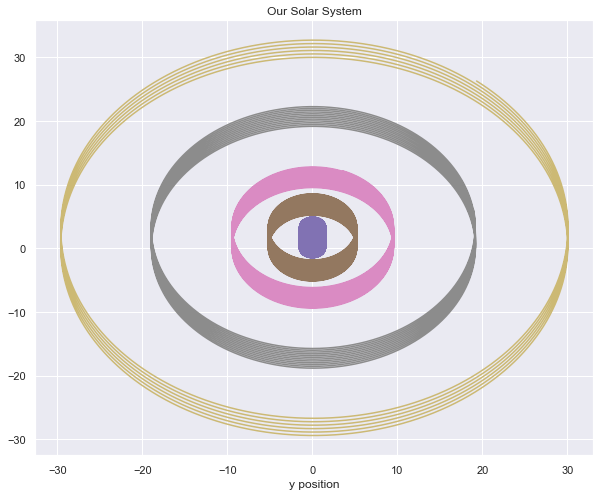

In [11]:
plt.figure(figsize = (10,8))

for i in range(9):
    plt.plot(pos[:,i][:,0], pos[:,i][:,1])

plt.title("Our Solar System")
plt.xlabel("x position")
plt.xlabel("y position")

# 2. Creating a sound using the data and creating a wav file

## 2.1 - creating a sound wave:
---------------------------------------------------------------------------------------------------------------------------
I decided to use the x position values to do this. I could have also chosen x or y velocity values to do this too, or y positions but it ultimately doesn't matter too much since each have the same characteristics of 8 different periodic motions.

I just added the superimposed motions together to create a resulting motion that would characterize that of the solar system.

---------------------------------------------------------------------------------------------------------------------------

Text(0, 0.5, 'time')

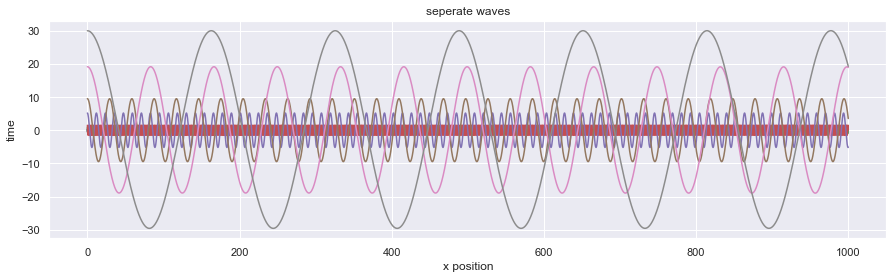

In [12]:
t = np.arange(0,tf,dt)
t = t[0:len(t)-1]

planet_positions = [pos[:,1][:,0],
                    pos[:,2][:,0],
                    pos[:,3][:,0],
                    pos[:,4][:,0],
                    pos[:,5][:,0],
                    pos[:,6][:,0],
                    pos[:,7][:,0],
                    pos[:,8][:,0]]

superposed_positions = np.zeros(len(t))

plt.figure(figsize = (15,4))

for i in planet_positions:
    superposed_positions += i
    plt.plot(t,i)

plt.title("seperate waves")
plt.xlabel("x position")
plt.ylabel("time")

#### The resulting wave:

This will be the sound of our solar system, what we will be using in the audio files and to do fft manipulations on.

Text(0, 0.5, 'time')

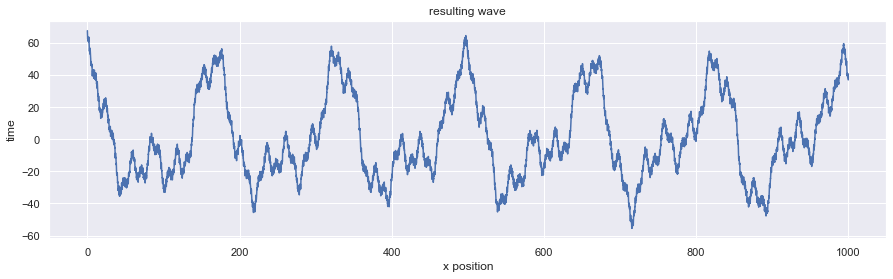

In [13]:
plt.figure(figsize = (15,4))
plt.plot(t,superposed_positions)
plt.title("resulting wave")
plt.xlabel("x position")
plt.ylabel("time")

## 2.2 - creating a wav file from the superposed planet positions

---------------------------------------------------------------------------------------------------------------------------
In this section, we will be creating audio out of this data.

In the next section, we will be doing an FFT transform on the position data obtained above, manipulate it, and try to create something more audible.

---------------------------------------------------------------------------------------------------------------------------
#### Parameters: sample rate, longest period, number of measurements:
To write the audio file or start an FFT analysis
it is important to determine the sample rate, which is effectively the smallest timestep between recordings/measurements or, the amount of measurements made in a second. The fourier transform is a sum, and the samplerate gives a start to this sum. It starts with the highest possible frequency, and then with each timestep, it begins to add lower frequencies as $N$ increases.

You can see this in the fourier transform as it follows, with $T_0$ being the longest possible period and $\frac{1}{T_0} $corresponding to the highest frequency beginning at $N=1$:

$$f(t) = \dfrac{a_0}{2} + \sum_{N=1}^{\infty} a_N \cos\left(\dfrac{2N\pi}{T_0}t\right) + b_N \sin\left(\dfrac{2N\pi}{T_0}t\right)$$

This is why we establish these parameters before we begin the tranform. Because we will need them for it.

However, this doesn't stop us from scaling the samplerate when writing audiofile to make it shorter. But for FFT analysis this is more complicated and we will not be doing this here.

---------------------------------------------------------------------------------------------------------------------------

In [14]:
!pip install playsound==1.2.2
from playsound import playsound

In [15]:
samplerate = int(n/tf)

#### Scaling the samplerate and position values:

---------------------------------------------------------------------------------------------------------------------------
Below you might notice that I multiplied the samplerate by 400. This is just done to make the sound audible. As said above, the samplerate simply determines the maximum frequency in a dataset, and so to multiply it, we are just scaling the frequencies (or time between measurements) of the sound. This is basically just compressing the sound, and allows us to be able to listen to this data even though all its frequencies are very low.

You also might notice that I also multiplied the position values by a factor of 5000. This is just to make it loud enough to hear.

---------------------------------------------------------------------------------------------------------------------------

In [16]:
write("solar_system_symphony.wav", samplerate*300, (superposed_positions*5000).astype(np.int16))

In [17]:
playsound("solar_system_symphony.wav")

# 3. Changing the sound via FFT Manipulations

---------------------------------------------------------------------------------------------------------------------------
So, that didn't exactly sound like a symphony. Maybe we can try doing a couple different forms of FFT transformations to analyze the sound or just try to make it sound better.

---------------------------------------------------------------------------------------------------------------------------
I will be doing 3 different sorts of manipulations. 

1) I will be adjusting the amplitude levels of the frequency peaks

2) I will be cleaning up redundant noise __(we will listen to this resulting sound)__

3) I will create one sound where only outer planets can be heard, and one where only the inner planets can be heard. I will do this by eliminating frequencies __(we will also listen to these resulting sounds)__

--------------------------------------------------------------------------------------------------------------------------

## 3.1 - Visualizing and dissecting the fourier transform

---------------------------------------------------------------------------------------------------------------------------
#### Initial FFT visualization (scaling, negative frequencies, np.abs())
Since the fourier transform returns information about phase and amplitude for a frequency range, we graph amplitudes on the y axis and frequency on the x-axis. Phase information is encoded in the imaginary/real balance of the amplitude information given by the transform. Since the magnitude of the amplitude data is preserved regardless of phase, we use np.abs() to get the most information out of the data. Basically this means that we use real values to write wav files, but for FFT transforms, it gives us imaginary values and we just have to consider the absolute value of this. (https://math.stackexchange.com/questions/275115/why-do-fourier-transforms-use-complex-numbers) this post sums the idea up well.


Below is a graph of frequency and respective amplitude values for the above position data. The scale here goes to 50 hz, but I scale the x-axis from (0,4.5) because this is where all the frequency peaks live. 
I only graph positive frequencies here because it is the most useful and tangible visual, however both negative and positive frequencies (and respective amplitudes) will be important to adjust in order to conduct an inverse fourier transform in part 4.


#### The frequency peaks:
Below this graph, you can see two zoomed in graphs of this transform. It is easier to see here that each peak, as we would expect (there are 8 for each planet -  the sun is in there too but I don't want to mention that too much for the sake of getting to the point). This shows that the fft transform is correct, and also tells us about our system! 

#### Normalization:
We use a normalization here of 2/N for this dataset. We will have to undo this when we perform the inverse fourier transform in 1.3

#### Usefulness of Visualizing before manipulating:
Before conducting each manipulation, it is important that we visualize our data so we know exactly what choices to make. FFT manipulations are really up for choice and there are different choices to make based on what you want to accomplish. I will explain my choices for things down below using these visuals.

---------------------------------------------------------------------------------------------------------------------------


(0.0, 4.5)

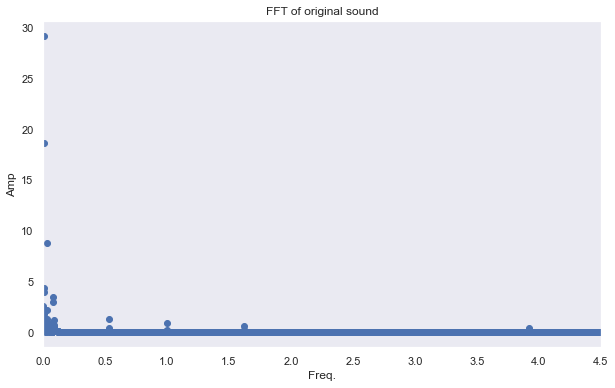

In [18]:
#taking the transform
dataf = (2/(n))*fft(superposed_positions)
freq = fftfreq(n,dt)

#visualizing the transform
plt.figure(figsize=(10,6))
plt.scatter(freq[0:n//2], np.abs(dataf[0:n//2]))
plt.xlabel('Freq.')
plt.ylabel('Amp')
plt.title("FFT of original sound")
plt.grid()
plt.xlim(0,4.5) 

taking a closer look..... we can see the frequencies at which each planet orbits!

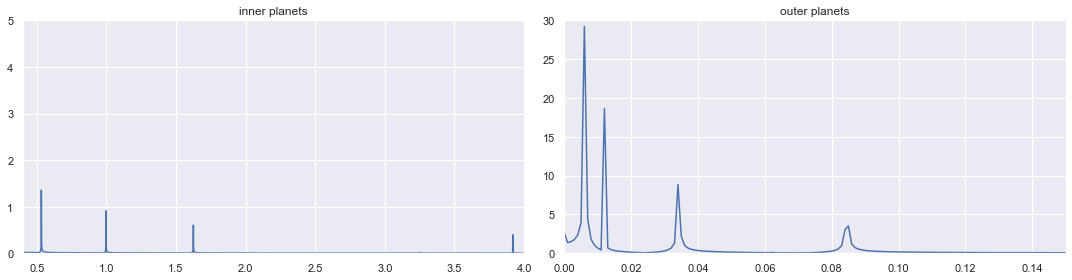

In [19]:
dataf_cut = dataf[0:n//2]
freq_cut = freq[0:n//2]

plt.figure(figsize = (15,4))

plt.subplot(1,2,1)
plt.plot(freq_cut, np.abs(dataf_cut))
plt.ylim(0,5)
plt.xlim(0.4,4)
plt.title("inner planets")

plt.subplot(1,2,2)
plt.plot(freq_cut, np.abs(dataf_cut))
plt.ylim(0,30)
plt.xlim(0,0.15)
plt.title("outer planets")

plt.tight_layout()

## 3.2 - FFT manipulation 1: modifying the amplitude distribution among the planets
---------------------------------------------------------------------------------------------------------------------------
Here, I want to add amplitude to some of the smaller frequency peaks to try and make them more audible compared to the ones with large amplitudes. I want to even out the amplitude distribution a bit more, just to see what comes out.

Below, I visualize the peaks that I want to amplify so that I know which boundaries in which I need to mask and multiply out these values to achieve this goal.

I don't know if this will make it sound better, but we will see. This is an investigation.

---------------------------------------------------------------------------------------------------------------------------

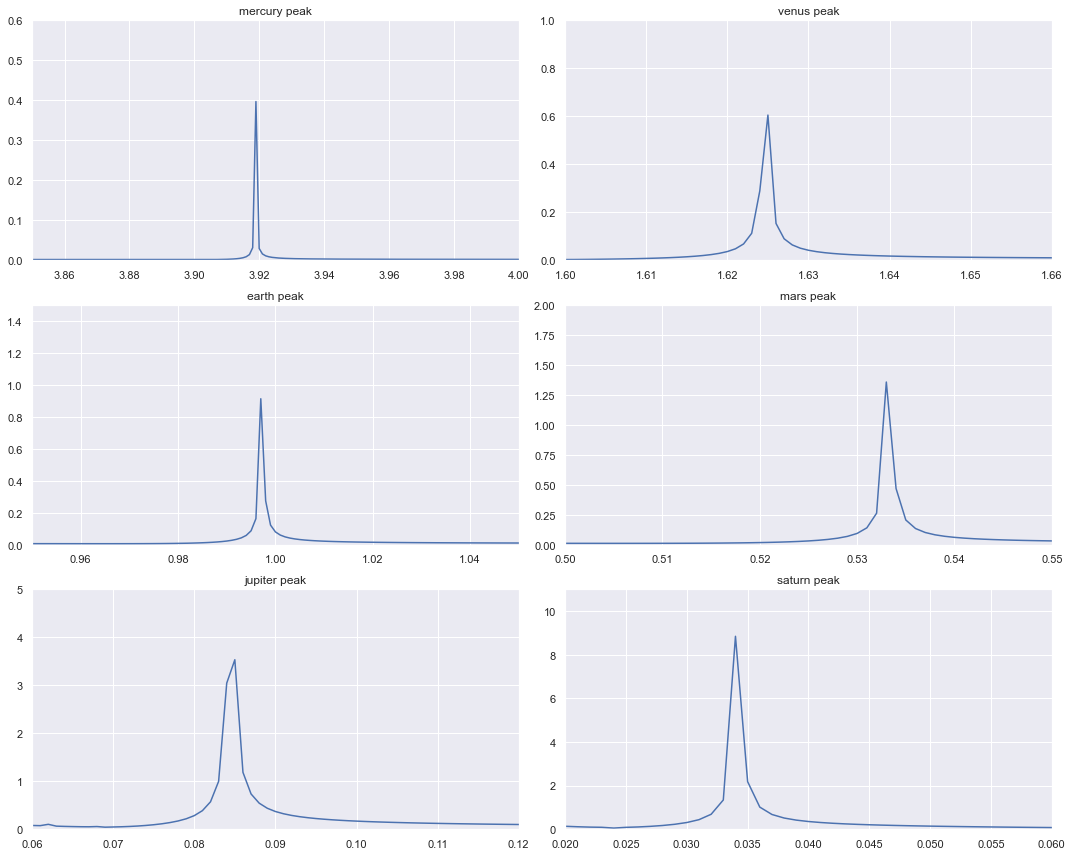

In [20]:
plt.figure(figsize = (15,12))
plt.subplot(3,2,1)
plt.plot(freq_cut, np.abs(dataf_cut))
plt.ylim(0,0.6)
plt.xlim(3.85,4)
plt.title("mercury peak")

plt.subplot(3,2,2)
plt.plot(freq_cut, np.abs(dataf_cut))
plt.ylim(0,1)
plt.xlim(1.6,1.66)
plt.title("venus peak")

plt.subplot(3,2,3)
plt.plot(freq_cut, np.abs(dataf_cut))
plt.ylim(0,1.5)
plt.xlim(0.95,1.05)
plt.title("earth peak")

plt.subplot(3,2,4)
plt.plot(freq_cut, np.abs(dataf_cut))
plt.ylim(0,2)
plt.xlim(0.5,0.55)
plt.title("mars peak")

plt.subplot(3,2,5)
plt.plot(freq_cut, np.abs(dataf_cut))
plt.ylim(0,5)
plt.xlim(0.06,0.12)
plt.title("jupiter peak")

plt.subplot(3,2,6)
plt.plot(freq_cut, np.abs(dataf_cut))
plt.ylim(0,11)
plt.xlim(0.02,0.06)
plt.title("saturn peak")

plt.tight_layout()

---------------------------------------------------------------------------------------------------------------------------
#### Amplitude value choices:
I want:

- saturn's amplitude peak to be around 15 (will multiply the area by x1.8)

- jupiter's peak to be around 12 (x3.4)

- mars's peak to be around 10 (x6.6)

- earth's peak to be around 8 (x8)

- venus's peak to be around 6 (x10)

- mercury's peak to be around 4 (x10)

these multipliers are just based on eyeballing. These exact amplitude values are not important. There are many ways which someone could choose to do this, and here i'm being approximate because of the fact that this is not too important. Either way, weither or not I choose to eyeball or be exact, I will end up with my end goal of the amplitude peaks becoming successively smaller still while also balancing the distribution out a bit more so the amplitudes of the 6 inner most planets aren't as small compared to the 2 other ones.

I'm using the graphs above to figure out the bounds in which each of these peaks are located. This is where all the numbers in the cell below come from.

---------------------------------------------------------------------------------------------------------------------------

In [21]:
dataf_scaled = dataf_cut.copy()

dataf_scaled[int(0.020*1000):int(0.050*1000)] = dataf_scaled[int(0.020*1000):int(0.050*1000)]*1.8
dataf_scaled[int(0.07*1000):int(0.13*1000)] = dataf_scaled[int(0.07*1000):int(0.13*1000)]*3.4
dataf_scaled[int(0.51*1000):int(0.55*1000)] = dataf_scaled[int(0.51*1000):int(0.55*1000)]*6.6
dataf_scaled[int(0.98*1000):int(1.03*1000)] = dataf_scaled[int(0.98*1000):int(1.03*1000)]*8
dataf_scaled[int(1.61*1000):int(1.65*1000)] = dataf_scaled[int(1.61*1000):int(1.65*1000)]*10
dataf_scaled[int(3.9*1000):int(3.94*1000)] = dataf_scaled[int(3.9*1000):int(3.94*1000)]*10

#### Showing the before and after effect of scaling amplitudes
---------------------------------------------------------------------------------------------------------------------------
Before is stored in dataf_cut, after is stored in dataf_scaled

For the next fft manipulations, I'll be using dataf_scaled to continue.

---------------------------------------------------------------------------------------------------------------------------

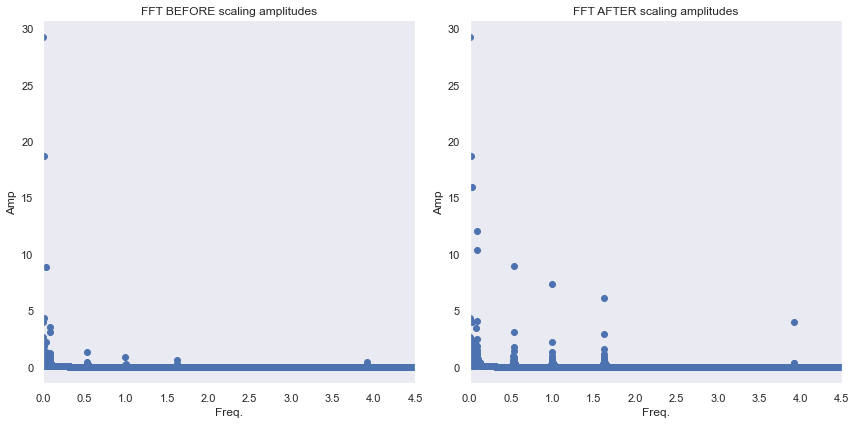

In [22]:
#visualizing the difference before and after scaling these amplitudes
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.scatter(freq_cut, np.abs(dataf_cut))
plt.xlabel('Freq.')
plt.ylabel('Amp')
plt.title("FFT BEFORE scaling amplitudes")
plt.grid()
plt.xlim(0,4.5)

plt.subplot(1,2,2)
plt.scatter(freq_cut, np.abs(dataf_scaled))
plt.xlabel('Freq.')
plt.ylabel('Amp')
plt.title("FFT AFTER scaling amplitudes")
plt.grid()
plt.xlim(0,4.5)

plt.tight_layout()

## 3.3 - FFT Manipulation 2: Cutting out noise 
---------------------------------------------------------------------------------------------------------------------------

This manipulation will be simple. I just want to set amplitudes equal to 0 where they are negligable. This will eliminate noise from frequencies which may have been caused by the slight error in the verlocity verlet method, and will help the main frequencies stand out in the sound.

This means I will have to choose an amplitude that I consider to be negligable. To do this, we visualize the FFT graph from the scaled data above, and want to focus primarily on y-axis values that correspond to lower amplitudes. I will do this by scaling the y axis in my graph.

---------------------------------------------------------------------------------------------------------------------------

(0.0, 4.5)

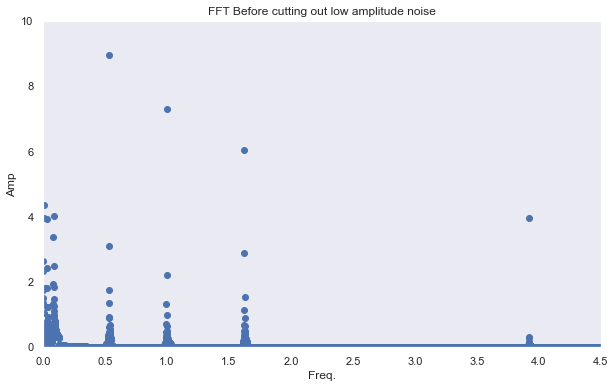

In [23]:
#visualizing the transform
plt.figure(figsize=(10,6))
plt.scatter(freq_cut, np.abs(dataf_scaled))
plt.xlabel('Freq.')
plt.ylabel('Amp')
plt.grid()
plt.title("FFT Before cutting out low amplitude noise")
plt.ylim(0,10)
plt.xlim(0,4.5)

#### Cutting out amplitudes below 3

---------------------------------------------------------------------------------------------------------------------------
I'm choosing this value because the noise is quite murky and I want to eliminate as much fuzzy noise as possible. It is on the higher side, but not high enough that it will eliminate amplitude values corresponding to any of the planet frequencies, which are the ones we want to desperately keep. I also like the reverb that cutting out higher amplitudes got me when doing this transform in my last project.

---------------------------------------------------------------------------------------------------------------------------

In [24]:
dataf_3_right = dataf_scaled.copy()
dataf_3_right[np.abs(dataf_scaled)<3] = 0

#### Again, we can visualize the before and after of this effect:

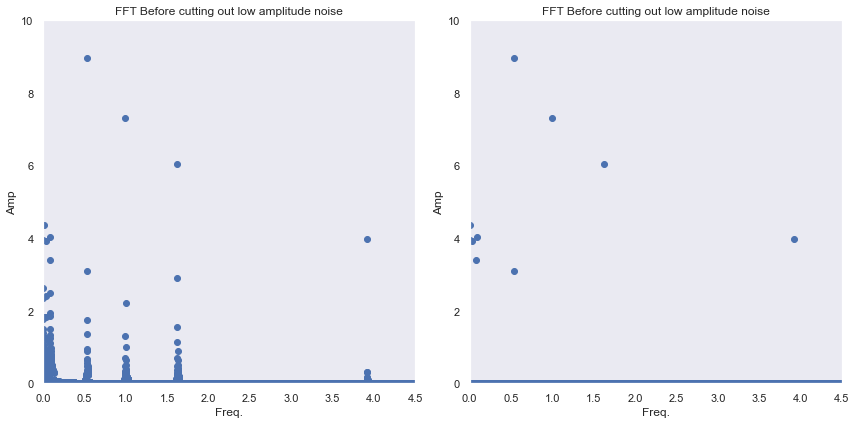

In [25]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.scatter(freq_cut, np.abs(dataf_scaled))
plt.xlabel('Freq.')
plt.ylabel('Amp')
plt.grid()
plt.title("FFT Before cutting out low amplitude noise")
plt.ylim(0,10)
plt.xlim(0,4.5)

plt.subplot(1,2,2)
plt.scatter(freq_cut, np.abs(dataf_3_right))
plt.xlabel('Freq.')
plt.ylabel('Amp')
plt.grid()
plt.title("FFT Before cutting out low amplitude noise")
plt.ylim(0,10)
plt.xlim(0,4.5)

plt.tight_layout()

## 3.4 - FFT Manipulation 3: Listening to only the inner/ outer planets
---------------------------------------------------------------------------------------------------------------------------
So here, we will be doing 2 FFT manipulations. One where we cut out all frequencies related to the inner planets so that we can have a dataset to listen to only outer planets, and one where we do the opposite so we can hear the inner planets.

---------------------------------------------------------------------------------------------------------------------------

In [26]:
dataf_inner_right = dataf_3_right.copy()
dataf_outer_right = dataf_3_right.copy()

dataf_inner_right[freq_cut<0.4] = 0

dataf_outer_right[freq_cut>0.4] = 0

#### Visualizing difference between inner and outer dataset:

Here you can see what I meant above.

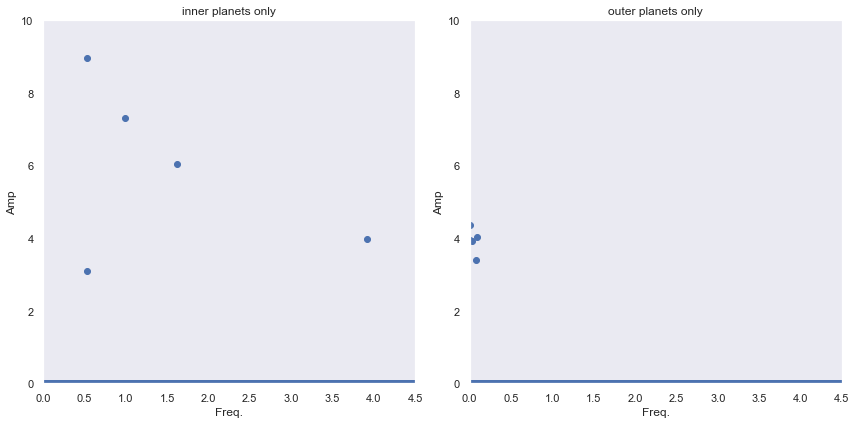

In [27]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.scatter(freq_cut, np.abs(dataf_inner_right))
plt.xlabel('Freq.')
plt.ylabel('Amp')
plt.grid()
plt.title("inner planets only")
plt.ylim(0,10)
plt.xlim(0,4.5)

plt.subplot(1,2,2)
plt.scatter(freq_cut, np.abs(dataf_outer_right))
plt.xlabel('Freq.')
plt.ylabel('Amp')
plt.grid()
plt.title("outer planets only")
plt.ylim(0,10)
plt.xlim(0,4.5)

plt.tight_layout()

# 4. Taking the inverse fourier transform and creating the new wav files
---------------------------------------------------------------------------------------------------------------------------
Here we come to the end of our FFT journey.

#### Remember, we have only been modifying the FFT for positive frequencies:
If you recall our discussion in 3.1, we talked about the fact that we only modified the fft using positive frequency values. However, since the FFT returns both positive and negative of these values, we will have to mirror our modifications, as the negative frequency side will be unmodified. 

To do this, in 4.1 below I will just mirror the modified side's amplitude information, and concatenate those two arrays together so they mirror each other.

These are the arrays that we will feed into the IFFT. Then we will use the data from the IFFT to get our position and time data back, and make the new wav files with it.

---------------------------------------------------------------------------------------------------------------------------

## 4.1 - Completing the amplitude datasets to prepare for inverse fourier transform

In [28]:
dataf_scaled_left = np.flip(dataf_scaled)
dataf_scale = np.concatenate((dataf_scaled,dataf_scaled_left), axis = 0)

dataf_3_left = np.flip(dataf_3_right)
dataf_3 = np.concatenate((dataf_3_right,dataf_3_left), axis = 0)

dataf_inner_left = np.flip(dataf_inner_right)
dataf_inner = np.concatenate((dataf_inner_right,dataf_inner_left), axis = 0)

dataf_outer_left = np.flip(dataf_outer_right)
dataf_outer = np.concatenate((dataf_outer_right,dataf_outer_left), axis = 0)

#### Full FFTs visualized

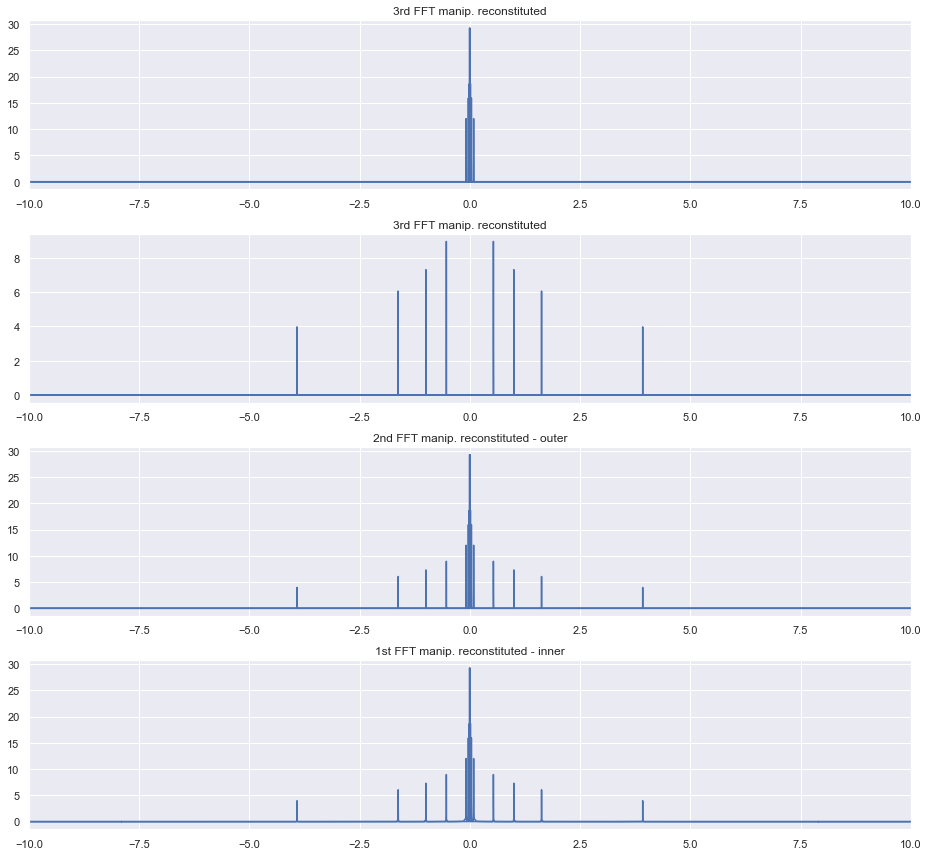

In [29]:
plt.figure(figsize = (13,12))

plt.subplot(4,1,1)
plt.plot(freq, np.abs(dataf_outer))
plt.title("4th FFT manip. reconstituted")
plt.xlim(-10,10)

plt.subplot(4,1,2)
plt.plot(freq, np.abs(dataf_inner))
plt.title("3rd FFT manip. reconstituted")
plt.xlim(-10,10)

plt.subplot(4,1,3)
plt.plot(freq, np.abs(dataf_3))
plt.title("2nd FFT manip. reconstituted - outer")
plt.xlim(-10,10)

plt.subplot(4,1,4)
plt.plot(freq, np.abs(dataf_scale))
plt.title("1st FFT manip. reconstituted - inner")
plt.xlim(-10,10)

plt.tight_layout()

## 4.2 - Taking the IFFTs to be able to turn back into wav files
---------------------------------------------------------------------------------------------------------------------------

#### Undoing normalization and using np.real for the IFFT
Again, we have to be considerate to the fact that we need to under the normalization we did when first taking the FFT, and also to feed the wav file real values only using np.real().

#### Samplerate and x position scale:
Also, to match the compression and modification of the original wav file, once the IFFT is taken, we need to again multiply position values by 5000, and scale the samplerate by 300.

---------------------------------------------------------------------------------------------------------------------------

In [30]:
data_scaled = ifft(0.5*n*dataf_scale) #notice the reversing of normalization
write("solar_system_symphony_scaled.wav", samplerate*300, (np.real(data_scaled)*5000).astype(np.int16))

data_3 = ifft(0.5*n*dataf_3) 
write("solar_system_symphony_3.wav", samplerate*300, (np.real(data_3)*5000).astype(np.int16))

data_outer = ifft(0.5*n*dataf_outer) 
write("solar_system_symphony_outer.wav", samplerate*300, (np.real(data_outer)*5000).astype(np.int16))

data_inner = ifft(0.5*n*dataf_inner) 
write("solar_system_symphony_inner.wav", samplerate*300, (np.real(data_inner)*5000).astype(np.int16))

# 5. Listening to the results
---------------------------------------------------------------------------------------------------------------------------
Well. No matter which manipulations I applied, I never got anything to sound very musical at all. However, the products sound quite comedic. I find that when I did transform 1, it ended up adding more fuzz which I didn't want, but it is an interesting result. My favorite was the last one of the inner planets. It sounds like something our of a horror movie.

---------------------------------------------------------------------------------------------------------------------------

#### Original

In [36]:
playsound("solar_system_symphony.wav")

#### Transform 1 (scaling amplitudes of frequency peaks):

In [37]:
playsound("solar_system_symphony_scaled.wav")

#### Transform 2 (eliminating amplitudes below 3):

In [38]:
playsound("solar_system_symphony_3.wav")

#### Transform 3 (outer, then inner):

In [39]:
playsound("solar_system_symphony_outer.wav")

In [40]:
playsound("solar_system_symphony_inner.wav")

# _fin_